In [64]:
import string
import unicodedata
import torch
import sys
import torch.nn as nn
import re
from torch.utils.data import Dataset,DataLoader
from itertools import chain
from tqdm import tqdm 
import matplotlib.pyplot as plt
from utils import RNN, device
import numpy as np
from torch.utils.data import Subset
from torch.distributions import Multinomial

In [3]:
## Liste des symboles autorisés
LETTRES = string.ascii_letters + string.punctuation+string.digits+' '
# +1 because we start 'a' as 1 
TAILLE_VOCA = len(LETTRES)+1
## Dictionnaire index -> lettre
id2lettre = dict(zip(range(1,len(LETTRES)+1),LETTRES))
id2lettre[0]='' ##NULL CHARACTER
## Dictionnaire lettre -> index
lettre2id = dict(zip(id2lettre.values(),id2lettre.keys()))

In [4]:
def normalize(s):
    """ Nettoyage d'une chaîne de caractères. """
    return ''.join(c for c in unicodedata.normalize('NFD', s) if  c in LETTRES)

def string2code(s):
    """ Transformation d'une chaîne de caractère en tenseur d'indexes """
    return torch.tensor([lettre2id[c] for c in normalize(s)])

def code2string(t):
    """ Transformation d'une liste d'indexes en chaîne de caractères """
    if type(t) !=list:
        t = t.tolist()
    return ''.join(id2lettre[i] for i in t)

class TrumpDataset(Dataset):
    def __init__(self,text,maxsent=None,maxlen=None):
        """  Dataset pour les tweets de Trump
            * text : texte brut
            * maxsent : nombre maximum de phrases.
            * maxlen : longueur maximale des phrases.
        """
        maxlen = maxlen or sys.maxsize
        full_text = normalize(text)
        self.phrases = [p[:maxlen].strip()+"." for p in full_text.split(".") if len(p)>0]
        if maxsent is not None:
            self.phrases=self.phrases[:maxsent]
        self.MAX_LEN = max([len(p) for p in self.phrases])

    def __len__(self):
        return len(self.phrases)
    def __getitem__(self,i):
        t = string2code(self.phrases[i])
        t = torch.cat([torch.zeros(self.MAX_LEN-t.size(0),dtype=torch.long),t])
        return t[:-1],t[1:]

In [5]:
class Embedder_RNN(nn.Module):
    
    def __init__(self,taille_voca,dim_latent):
        
        super(Embedder_RNN, self).__init__()
        
        self.taille_voca = taille_voca
        self.dim_latent = dim_latent
        
        self.embedder = nn.Linear(self.taille_voca ,self.taille_voca)
        self.rnn = RNN(self.taille_voca ,self.dim_latent,self.taille_voca)
        
        
    def forward(self, x):
        return self.rnn(self.embedder(x))

In [6]:
PATH = "data/"
TAILLE_DATASET = 100
trump_dataset = TrumpDataset(open(PATH+"trump_full_speech.txt","rb").read().decode(),maxlen=1000)
subset_indices = torch.randint(1,1000,(TAILLE_DATASET,))  # Choisissez les indices que vous souhaitez inclure
trump_dataset = Subset(trump_dataset, subset_indices)

In [14]:
BATCH_SIZE = 32

data_trump = DataLoader(trump_dataset, batch_size= BATCH_SIZE, shuffle=True)

EPOCHS = 30
CE = nn.CrossEntropyLoss()

LEARNING_RATE = 1e-3
dim_lat = 10

model = Embedder_RNN(TAILLE_VOCA,dim_lat)

optimizer = torch.optim.SGD(params=model.parameters() ,lr=LEARNING_RATE)

losses_tr = []

for _ in tqdm(range(EPOCHS)):
    
    temp_loss = []
    for x,y in tqdm(data_trump):

        x_onehoted = torch.eye(TAILLE_VOCA)[x]
        x_embedded = model.embedder(x_onehoted)
        x_embedded = x_embedded.permute(1,0,2)
        

        y_onehoted = torch.eye(TAILLE_VOCA)[y]
        y_embedded = model.embedder(y_onehoted)
        y_embedded = y_embedded.permute(1,0,2)

        optimizer.zero_grad()

        _ , liste_h = model.rnn(x_embedded)

        liste_h = torch.stack(liste_h)
        liste_h_softmax = model.rnn.decode(liste_h,type='many-to-many')

        y_embedded_softmax = y_embedded.softmax(dim=2)
        loss = CE(y_embedded,liste_h_softmax)
            
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            temp_loss.append(loss.item())

    losses_tr.append(np.mean(temp_loss))

  0%|                                                     | 0/4 [00:00<?, ?it/s]


100%|███████████████████████████████████████████| 30/30 [03:27<00:00,  6.90s/it]


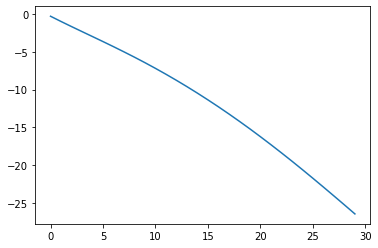

In [15]:
plt.plot(losses_tr)

### Inference

In [53]:
def cara_embedding(first_cara,model):
    first_cara_onehotted = torch.eye(TAILLE_VOCA)[string2code(first_cara)]
    first_cara_embedded = model.embedder(first_cara_onehotted)
    return first_cara_embedded.view(first_cara_embedded.size(0),1,first_cara_embedded.size(1))

In [67]:
first_cara = 'alors'
sentence = first_cara
nb_generation = 50

first_cara_embedded = cara_embedding(first_cara,model)

h_i , _  = model.rnn(first_cara_embedded)
probas = model.rnn.decode(h_i,type='many-to-one').softmax(dim=1)
# x_i =  torch.eye(TAILLE_VOCA)[torch.argmax(probas).item()]
# sentence += code2string([torch.argmax(probas).item()])

multinomial_dist = Multinomial(1, probs=probas)
sample = multinomial_dist.sample()
x_i = multinomial_dist.sample()
sentence += code2string([torch.argmax(x_i).item()])

for _ in range(nb_generation):
    
    h_i = model.rnn.one_step(x_i,h_i)
    
    probas = model.rnn.decode(h_i,type='many-to-one').softmax(dim=1)
    multinomial_dist = Multinomial(1, probs=probas)
    x_i = multinomial_dist.sample()
    sentence += code2string([torch.argmax(x_i).item()])
   
    #     x_i =  torch.eye(TAILLE_VOCA)[torch.argmax(probas).item()]
    #     sentence += code2string([torch.argmax(probas).item()])

sentence

'alors(u.2=i)xRdO(WN1\'`RJGI}` ?,j7ALtKAH3YE{zYb"X#A^Xi@aW'